In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# importing relevant libraries
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

##  reading the data  in again for the second model

In [88]:

#Import the data
movie_titles_data = pd.read_csv('../../data/ml-latest-small/movies.csv')
raw_data = pd.read_csv('../../data/ml-latest-small/ratings.csv')

In [89]:

#Merge our two data sources
merged_data = pd.merge(raw_data, movie_titles_data, on='movieId')
merged_data.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [90]:
#Calculate aggregate data
merged_data.groupby('title')['rating'].mean().sort_values(ascending = False)
merged_data.groupby('title')['rating'].count().sort_values(ascending = False)

title
Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
                                                                                 ... 
Late Night Shopping (2001)                                                          1
Late Night with Conan O'Brien: The Best of Triumph the Insult Comic Dog (2004)      1
Late Shift, The (1996)                                                              1
Latter Days (2003)                                                                  1
'71 (2014)                                                                          1
Name: rating, Length: 9719, dtype: int64

In [91]:
merged_data

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


### creating a column called # of ratings 

In [92]:
#Create a DataFrame and add the number of ratings to is using a count method
ratings_data = pd.DataFrame(merged_data.groupby('title')['rating', 'movieId', 'userId'].mean())
ratings_data.head()

<ipython-input-92-3c77d529a0c5>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ratings_data = pd.DataFrame(merged_data.groupby('title')['rating', 'movieId', 'userId'].mean())


,rating,movieId,userId
title,,,
'71 (2014),4.0,117867.0,610.0
'Hellboy': The Seeds of Creation (2004),4.0,97757.0,332.0
'Round Midnight (1986),3.5,26564.0,354.5
'Salem's Lot (2004),5.0,27751.0,345.0
'Til There Was You (1997),4.0,779.0,229.0


In [93]:
ratings_data['# of ratings'] = merged_data.groupby('title')['rating'].count()
ratings_data.head()

,rating,movieId,userId,# of ratings
title,,,,
'71 (2014),4.0,117867.0,610.0,1
'Hellboy': The Seeds of Creation (2004),4.0,97757.0,332.0,1
'Round Midnight (1986),3.5,26564.0,354.5,2
'Salem's Lot (2004),5.0,27751.0,345.0,1
'Til There Was You (1997),4.0,779.0,229.0,2


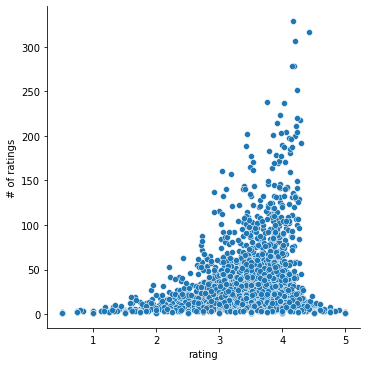

In [94]:
sns.relplot(x='rating' , y='# of ratings' , data=ratings_data)

In [107]:
#Create the ratings matrix and get user ratings for 'Heat (1995)' and `Toy Story (1995)`
ratings_matrix = merged_data.pivot_table(index='userId',columns='title',values='rating')
heat_user_ratings = ratings_matrix['Heat (1995)']
toy_story_user_ratings = ratings_matrix['Toy Story (1995)']
ratings_matrix.corrwith(toy_story_user_ratings)['Heat (1995)']

/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


0.10646484013036762

In [108]:
ratings_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [97]:
#Calculate correlations and source recommendations
correlation_with_heat = pd.DataFrame(ratings_matrix.corrwith(heat_user_ratings))
correlation_with_heat

,0
title,
'71 (2014),NaN
'Hellboy': The Seeds of Creation (2004),NaN
'Round Midnight (1986),NaN
'Salem's Lot (2004),NaN
'Til There Was You (1997),NaN
...,...
eXistenZ (1999),-0.157500
xXx (2002),-0.070244
xXx: State of the Union (2005),-1.000000


In [98]:

#Calculate correlations and source recommendations
correlation_with_heat = pd.DataFrame(ratings_matrix.corrwith(heat_user_ratings))
correlation_with_heat.dropna().sort_values(0, ascending = False).head(15)

/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,0
title,
Another 48 Hrs. (1990),1.0
Ghosts of Mississippi (1996),1.0
Escape to Witch Mountain (1975),1.0
Andre (1994),1.0
Bread and Tulips (Pane e tulipani) (2000),1.0
Police Story 2 (Ging chaat goo si juk jaap) (1988),1.0
Brassed Off (1996),1.0
Police Story (Ging chaat goo si) (1985),1.0
Music of the Heart (1999),1.0


### creating the actual model found with  the movie heat, the number of ratings, and the correlation found with other movies.

In [11]:
#Add the number of ratings and rename columns
correlation_with_heat = correlation_with_heat.join(ratings_data['# of ratings'])
correlation_with_heat.columns = ['Corr. With Heat Ratings', '# of Ratings']
correlation_with_heat.index.names = ['Movie Title']

In [12]:
#Get new recommendations from movies that have more than 50 ratings
correlation_with_heat[correlation_with_heat['# of Ratings'] > 50].sort_values('Corr. With Heat Ratings', ascending = False).head(10)

,Corr. With Heat Ratings,# of Ratings
Movie Title,,
Heat (1995),1.000000,102
Philadelphia (1993),0.686060,66
Slumdog Millionaire (2008),0.662325,71
Léon: The Professional (a.k.a. The Professional) (Léon) (1994),0.651800,133
"Bourne Ultimatum, The (2007)",0.611546,81
Aliens (1986),0.597448,126
I Am Legend (2007),0.574709,62
Inception (2010),0.565437,143
Army of Darkness (1993),0.550348,51


In [152]:
def movie_recommendations(movie_name):
    user_ratings = ratings_matrix[movie_name]
    correlation_with_movie = pd.DataFrame(ratings_matrix.corrwith(user_ratings))
    correlation_with_movie = correlation_with_movie.join(ratings_data['# of ratings'])
    correlation_with_movie.columns = ['Distance', '# of Ratings']
    correlation_with_movie.index.names = ['Movie Title']
    return correlation_with_movie[correlation_with_movie['# of Ratings'] > 50].sort_values('Distance', ascending = False).iloc[1:,:].head(10)

In [153]:
r_m = ratings_matrix.replace(np.nan, 0)

In [154]:
ratings_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [155]:
#f'Corr. With {movie_name}'

In [156]:
movie_recommendations('Shrek 2 (2004)')

/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Distance,# of Ratings
Movie Title,,
Shrek (2001),0.821400,170
Gone in 60 Seconds (2000),0.642714,61
How to Train Your Dragon (2010),0.639178,53
Eraser (1996),0.635763,64
Sense and Sensibility (1995),0.618499,67
Johnny Mnemonic (1995),0.611842,53
Field of Dreams (1989),0.596883,56
"Monsters, Inc. (2001)",0.591414,132
Kung Fu Panda (2008),0.579984,54


In [144]:
movie_recommendations('Harry Potter and the Chamber of Secrets (2002)')

/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Distance,# of Ratings
Movie Title,,
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.884597,107
Harry Potter and the Order of the Phoenix (2007),0.825499,58
Harry Potter and the Half-Blood Prince (2009),0.692219,58
Harry Potter and the Goblet of Fire (2005),0.680157,71
Harry Potter and the Prisoner of Azkaban (2004),0.662563,93
Star Trek (2009),0.662398,59
Pretty Woman (1990),0.658711,135
28 Days Later (2002),0.655416,58
How to Train Your Dragon (2010),0.652580,53


In [146]:
movie_recommendations('Inception (2010)')

/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mallorywilson/opt/anaconda3/envs/flatiron/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Distance,# of Ratings
Movie Title,,
"Full Monty, The (1997)",0.909324,56
"Crow, The (1994)",0.859338,64
Grumpier Old Men (1995),0.836421,52
Hook (1991),0.817990,53
Desperado (1995),0.807960,66
Interview with the Vampire: The Vampire Chronicles (1994),0.789059,109
Maverick (1994),0.773249,74
Leaving Las Vegas (1995),0.753912,76
Animal House (1978),0.739351,62


### finding the RMSE score for the  rating dataset model above

In [18]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split #must use surprise

In [15]:

# for Surprise, we only need three columns from the dataset
data = ratings_data[['userId', 'movieId', 'rating']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader) #loads Pandas df 

# train-test-split
trainset, testset = train_test_split(data, test_size=.2)

In [16]:
 #instantiate SVD and fit the trainset
svd = SVD() # default values
svd.fit(trainset)

In [17]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7877


0.7877388912339476

In [84]:
ratings_matrix.to_csv('ratings_matrix.csv')

In [86]:
ratings_data.to_csv('dataframe.csv')

In [129]:
ratings_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
ratings_data.head()

,rating,movieId,userId,# of ratings
title,,,,
'71 (2014),4.0,117867.0,610.0,1
'Hellboy': The Seeds of Creation (2004),4.0,97757.0,332.0,1
'Round Midnight (1986),3.5,26564.0,354.5,2
'Salem's Lot (2004),5.0,27751.0,345.0,1
'Til There Was You (1997),4.0,779.0,229.0,2
